In [134]:
import numpy as np
import librosa
import librosa.display
import torchaudio
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, SpecFrequencyMask, SpecCompose
import torch
import random
import matplotlib.pyplot as plt


class AugmentedSpectrogramPlotter:
    def __init__(self, ext='.flac', sample_rate=22050, window_size=0.02, stride=0.01, power_spectrum=True, num_mels=80,
                 logscale=True, normalize=True, frq_bin=True, output_format='NFHT', should_augment=False,
                 noise=False, stretch=False, pitch_shift=False):

        assert output_format in ('NFHT', 'NFT', 'TNF'), 'Output format should be NFHT, NFT or TNF.'

        self.ext = ext
        self.sample_rate = sample_rate
        self.window_size = window_size
        self.stride = stride
        self.power_spectrum = power_spectrum
        self.num_mels = num_mels
        self.logscale = logscale
        self.normalize = normalize
        self.frq_bin = frq_bin
        self.output_format = output_format
        self.should_augment = should_augment
        self.noise = noise
        self.stretch = stretch
        self.pitch_shift = pitch_shift

        self.mel_basis = None if num_mels is None else \
            librosa.filters.mel(sr=sample_rate, n_fft=int(window_size * sample_rate), n_mels=num_mels)

    def augment(self, sample, noise=0, stretch=0, shift=0):
        if noise == 0:
            self.noise = False

        if stretch == 0:
            self.stretch = False

        if shift == 0:
            self.pitch_shift = False

        if self.noise:
            gauss_noise = Compose([
            AddGaussianNoise(min_amplitude=noise, max_amplitude=noise, p=1)
        ], p=1)
            sample = gauss_noise(samples=sample, sample_rate=self.sample_rate)

        if self.stretch:
            time_stretch = Compose([
            TimeStretch(min_rate=stretch, max_rate=stretch, p=1)
        ], p=1)
            sample = time_stretch(samples=sample, sample_rate=self.sample_rate)

        if self.pitch_shift:
            pitch_shift = Compose([
            PitchShift(min_semitones=-shift, max_semitones=shift, p=1)
        ], p=1)
            sample = pitch_shift(samples=sample, sample_rate=self.sample_rate)

        return sample

    def generate(self, path, noise, stretch, shift, specmask=False):
        if not path.endswith(self.ext):
            path = path + self.ext

        pcm, sample_rate = torchaudio.load(path, format="flac")  # wavfile.read(path)
        pcm = pcm.numpy().reshape(-1)

        assert sample_rate == self.sample_rate, f'Audio file did not have the expected sample rate: {path}'
        assert len(pcm) > int(self.window_size * self.sample_rate), f'PCM audio has too few samples: {path}'
        assert np.std(pcm) > 0, f'PCM audio is empty: {path}'

        if self.should_augment:
            pcm = self.augment(pcm, noise, stretch, shift)

        stft = librosa.stft(pcm.astype(np.float64), n_fft=int(self.window_size * self.sample_rate), window='hann',
                            hop_length=int(self.stride * sample_rate), dtype=np.complex128)

        spectrogram = np.abs(stft)

        if self.power_spectrum:
            spectrogram = spectrogram ** 2.
        if self.num_mels is not None:
            spectrogram = np.dot(self.mel_basis, spectrogram)
        if self.logscale:
            spectrogram = librosa.core.power_to_db(spectrogram, top_db=None)
        if self.normalize:
            axis = 1 if self.frq_bin else None
            mean, std = np.mean(spectrogram, axis=axis), np.std(spectrogram, axis=axis)
            spectrogram = ((spectrogram.T - mean) / (std + np.finfo(np.float64).eps)).T

        spect = spectrogram.astype(np.float32)

        if specmask:
            spec_freq_mask = SpecCompose([SpecFrequencyMask(min_mask_fraction=0.05, max_mask_fraction=0.15, p=1)])
            spect = spec_freq_mask(spect)

        return spect

def plot_spec(path):
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 10))

    # On the first subplot, show the original spectrogram
    spec_orig = augmenter.generate(path=path, noise=0, stretch=0, shift=0)
    img1 = librosa.display.specshow(spec_orig, x_axis='time', y_axis='mel', ax=ax[0])
    ax[0].set(title='Standard Mel Spectrogram')

    # On the second subplot, we introduce Gaussian Noise
    spec_2 = augmenter.generate(path=path, noise=0.003, stretch=0, shift=0)
    img2 = librosa.display.specshow(spec_2, x_axis='time', y_axis='mel', ax=ax[1])
    ax[1].set(title='Mel Spectrogram w. Gaussian Noise')

    # On the third subplot, we introduce time stretch
    spec_3 = augmenter.generate(path=path, noise=0.003, stretch=0.75, shift=0)
    img3 = librosa.display.specshow(spec_3, x_axis='time', y_axis='mel', ax=ax[2])
    ax[2].set(title='Mel Spectrogram w. Noise & Time Stretch')

    # On the third subplot, we introduce pitch shift
    spec_4 = augmenter.generate(path=path, noise=0.003, stretch=0.75, shift=6)
    img4 = librosa.display.specshow(spec_4, x_axis='time', y_axis='mel', ax=ax[3])
    ax[3].set(title='Mel Spectrogram w. Noise, Time Stretch & Shift')

    # On the fifth subplot, we introduce freq masking
    spec_5 = augmenter.generate(path=path, noise=0.003, stretch=0.75, shift=6)
    img5 = librosa.display.specshow(spec_5, x_axis='time', y_axis='mel', ax=ax[4])
    ax[4].set(title='Mel Spectrogram w. Noise, Time Stretch, Shift & Masking')

    fig.tight_layout()

    # We set a shared colorbar
    fig.colorbar(img1, ax=[ax[0], ax[1], ax[2], ax[3], ax[4]], format="%+2.f dB")

In [135]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    axes.set_xlabel("Time")
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)

    plt.show(block=False)

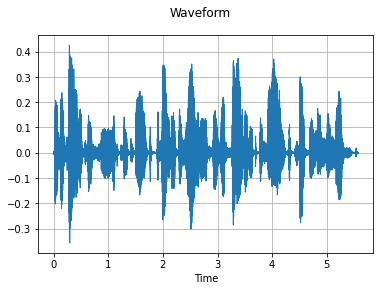

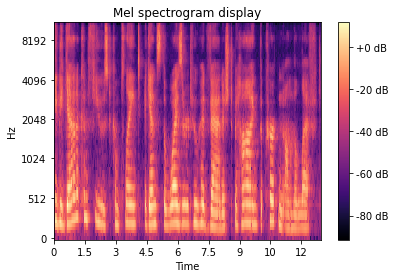

In [136]:
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
path = "./data/testclips/s61_c70968_u0.flac"

augmenter = AugmentedSpectrogramPlotter(normalize=False, noise=True, stretch=True, pitch_shift=True, should_augment=True)
spec = augmenter.generate(path=path, noise=0, stretch=0, shift=0)
waveform, sample_rate = torchaudio.load(path, format='flac')
plot_waveform(waveform, sample_rate)

fig, ax = plt.subplots()
img = librosa.display.specshow(spec, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='Mel spectrogram display')
fig.colorbar(img, ax=ax, format="%+2.f dB")

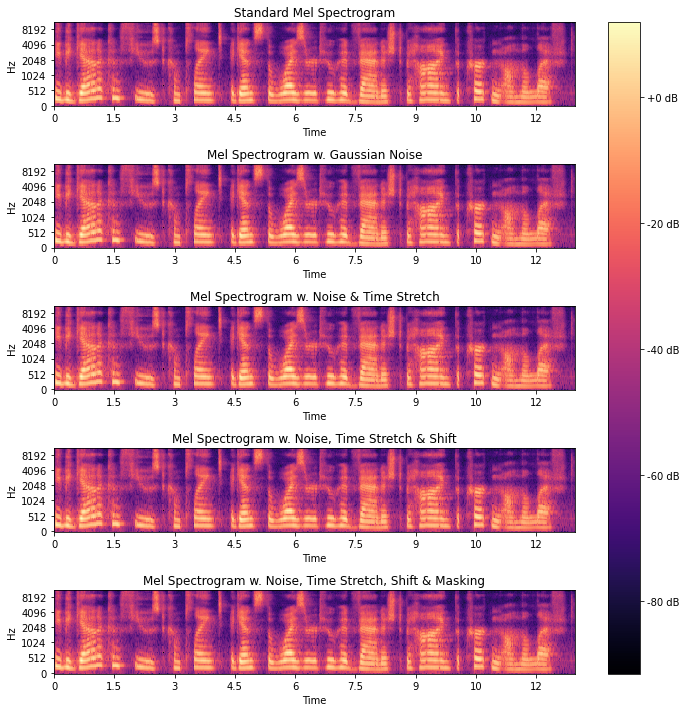

In [137]:
plot_spec(path)